# Prediction of the onset of thermoacoustic instabilities using Supervised machine learning
In this notebook we demonstrate how Automatic Machine LEarning (AutoML) can be used to train a machine learning algorithm to detect the onset of thermoacoustic instabilities.

In [71]:
import numpy as np
import pandas as pd
import nolds
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import numpy.polynomial.polynomial as poly
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler

In [50]:
def insert_periodic(noise, time, period_length, period_starts, period_amp, damp_amp, period_freq=1000, hanning=True):
    addition = np.zeros(len(noise))
    damping = np.ones(len(noise))
    # for each periodic section damp the noise amplitude and 
    for start in period_starts:
        
        if hanning:
            damping[start:start+period_length] = 1-damp_amp*np.hanning(period_length)
            addition[start:start+period_length] = period_amp*np.hanning(period_length)*0.5*np.sin(period_freq*2*3.14159*time[start:start+period_length])
        else:
            damping[start:start+period_length] = 1-damp_amp
            addition[start:start+period_length] = period_amp*0.5*np.sin(period_freq*2*3.14159*time[start:start+period_length])
    return noise*damping + addition

def gen_intermittent(noise, t, sin_amp, damp_amp):
    '''Function to generate a synthetic time series showing intermittent bursts of periodic behaviour.'''

    signal = np.concatenate([noise[:10000],
                           insert_periodic(noise[10000:20000], t[10000:20000], 100, [0], sin_amp, damp_amp),
                           insert_periodic(noise[20000:30000], t[20000:30000], 100, [1000,4000, 7000], sin_amp, damp_amp),
                           insert_periodic(noise[30000:40000], t[30000:40000], 100, [1000, 2000, 4000, 5000, 8000], sin_amp, damp_amp),
                           insert_periodic(noise[40000:50000], t[40000:50000], 100, [50, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], sin_amp, damp_amp),
                           insert_periodic(noise[50000:60000], t[50000:60000], 250, [0], sin_amp, damp_amp),
                           insert_periodic(noise[60000:70000], t[60000:70000], 250, [1000,4000, 7000], sin_amp, damp_amp),
                           insert_periodic(noise[70000:80000], t[70000:80000], 250, [1000, 2000, 4000, 5000, 8000], sin_amp, damp_amp),
                           insert_periodic(noise[80000:90000], t[80000:90000], 250, [50, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], sin_amp, damp_amp),
                           insert_periodic(noise[90000:100000],t[90000:100000], 500, [0], sin_amp, damp_amp),
                           insert_periodic(noise[100000:110000], t[100000:110000], 500, [1000,4000, 7000], sin_amp, damp_amp),
                           insert_periodic(noise[110000:120000], t[110000:120000], 500, [1000, 2000, 4000, 5000, 8000], sin_amp, damp_amp),
                           insert_periodic(noise[120000:130000], t[120000:130000], 500, [50, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], sin_amp, damp_amp),
                           insert_periodic(noise[130000:140000], t[130000:140000], 1000, [0], sin_amp, damp_amp),
                           insert_periodic(noise[140000:150000], t[140000:150000], 1000, [1000,4000, 7000], sin_amp, damp_amp),
                           insert_periodic(noise[150000:160000], t[150000:160000], 1000, [1000, 2000, 4000, 5000, 8000], sin_amp, damp_amp),
                           insert_periodic(noise[160000:170000], t[160000:170000], 1000, [50, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000], sin_amp, damp_amp),
                           insert_periodic(noise[170000:190000], t[170000:190000], 2000, [0], sin_amp, damp_amp),
                           insert_periodic(noise[190000:220000], t[190000:220000], 2000, [0, 10000, 15000], sin_amp, damp_amp),
                           insert_periodic(noise[220000:230000], t[220000:230000], 2000, [0, 1000, 4000, 6000, 8000], sin_amp, damp_amp),
                           insert_periodic(noise[230000:250000], t[230000:250000], 2000, [0, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 16000, 18000], sin_amp, damp_amp),
                           insert_periodic(noise[250000:300000], t[250000:300000], 50000, [0], 10, damp_amp, hanning=False),
                          ])
    return signal
def DFA_transform(signal, time_sig=None, time_window=4000, stepsize=100,
                  rolling=True, scale_range=(1, 2.7), scales=30,
                  detrend_order=2, n_jobs=1, **kwargs):
    '''Transforms the input signal into DFA space.

    Parameters
    ----------

    signal : np.array
        A 1D numpy array containing the time series on which to calculate the
        Hurst exponent

    scale_range : tuple, optional
        The range of scales over which to calculate the hurst exponent for each
        time window, given in powers of 10 of the number of data points. The
        scales used are linearly distributed over a log scale in this range.
        Unless a moving Hurst window is used, the scales should be selected to
        ensure scale invariance across all scales. The lower bound of the range
        should be at least 1 to ensure at least 10 data points are used in
        the smallest scale.

    scales : int, optional
        The number of scales to use in the calculation of the Hurst exponent.
        When method 'DFA' is used, the processing time is proportional to
        scales.

    time_window : int, optional
        The number of data points over which to carry oout the DFA
        i.e. the time window.

    rolling : bool, optional
        Indicator for whether to use a rolling or non-overlapping time window.

    stepsize : int, optional
        The number of data points between the start of each time window when
        using a rolling window. Ignored if rolling is False.

    Returns
    ----------

    Fs : numpy.array, shape(# time windows, scales)
        The values of Fw from which the Hurst exponent is calculated for each
        time window. Plot log(Fw) vs. log(scales) to check if signal is scale
        invariant.

    ws : The number of samples used in the calculation of each Fs value.
    '''

    # Turn the time series containing the fluctuating component of the Pressure
    # into a random walk
    walk = np.cumsum(signal - np.mean(signal))

    new_walk = slice_signal(walk, time_window, stepsize, rolling)
    K = new_walk.shape[0]

    # create the list of scales
    ws = np.logspace(scale_range[0], scale_range[1],
                     scales, base=10, dtype=np.int32)

    # Initialise Fs
    Fs = np.zeros([len(ws), K])

    # set the order of the detrending
    m = detrend_order

    def calc_dists(scale, i, new_walk, K, time_window, len_ws, m):
        # Initialise Fs
        Fs = np.zeros([len(ws), K])

        # pad timeseries and reshape so that the third dimension conatains a
        # non-overlapping wondow of the timeseries with size scale
        nw = np.floor_divide(time_window, scale)
        assert (nw > 0)
        x = new_walk[:, :int(nw * scale)].reshape(K, nw, scale)


        # Detrend the data by removing the mean or a polynomial fit fom each window
        fits = poly.polyfit(range(scale), x.reshape(-1, scale).transpose(), deg=m)
        trends = poly.polyval(list(range(scale)), fits)
        assert (trends.shape == (K * x.shape[1], scale))
        detrended = x.reshape(-1, scale) - trends
        detrended = detrended.reshape((K, -1, scale))

        # Find the RMS of all the detrended windows
        RMS = np.sqrt(np.mean(detrended ** 2, axis=-1))
        assert (RMS.shape == (K, x.shape[1]))

        # Find the rms across the detrended windows for each timestep and save
        Fs[i, :] = np.sqrt(np.mean(RMS ** 2, axis=-1))
        #assert(Fs.size == np.count_nonzero(Fs))
        return Fs

    # for each scale
    result = Parallel(n_jobs=n_jobs)(delayed(calc_dists)(scale, i, new_walk, K,
                                                         time_window, len(ws),
                                                         m) for i, scale in enumerate(ws))
    Fs = result[0]
    for res in result[1:]:
        Fs = Fs + res

    assert(Fs.size == np.count_nonzero(Fs))

    # if rolling windows are used then shift the signal so that when matched up
    # with the time from theoriginal signal, the time points refer to the time
    # at the end of the time window for each element in H
    if rolling:
        shift_Fs = shift(Fs, time_window//stepsize, axis=1, cval=np.nan)
        # dowmsample the time signal to the same stepsize
        time_sig = time_sig[:max(int(K*stepsize), len(time_sig)):stepsize]
        return np.log10(shift_Fs), np.log10(ws), time_sig
    else:
        time_sig = time_sig[:max(int(K*stepsize), len(time_sig)):stepsize]
        return np.log10(Fs), np.log10(ws), time_sig
def slice_signal(walk, time_window=4000, stepsize=100, rolling=True):
    # Split the timeseries into a 2d vector of time windows each of which
    # will have the Hurst exponent evaluated
    walk = np.array(walk).reshape(-1,)
    if rolling:
        # Pad the timeseries and then create a new array where each row is a
        # step of a rolling window across the signal
        padded_walk = np.pad(walk, (0, time_window), 'constant')
        new_walk = np.zeros((np.floor_divide(walk.shape[0], stepsize),
                                             time_window))

        try:
            for i in range(time_window):
                new_walk[:, i] = padded_walk[i:-(time_window+1-i):stepsize]
        except:
            for i in range(time_window):
                new_walk[:, i] = padded_walk[i:-(time_window+1-i):stepsize][:-1]
        K = new_walk.shape[0]

    else:
        K = np.floor_divide(walk.shape[0], time_window)
        new_walk = walk[:int(K*time_window)].reshape(K, time_window)
        assert(new_walk.shape == (K, time_window))

    return new_walk
def shift(array, sft_steps, axis=0, cval=np.nan):
    '''Function that shift a 1D or 2D array along a single axis.

    Parameters
    ----------

    array : np.array
        A 1D or 2D numpy array containing the array to be shifted.

    sft_steps : int
        The number of steps to shift the array by. Negative values shift the
        array backwards.

    axis : int, optional
        The axis along which to shift the array. Default is zero.

    cval : scalar, optional
        The value to insert where data is shifted from. Default is np.nan.

    Returns
    ----------

    new_array : numpy.array, shape(array.shape)
        The shifted array.
    '''

    # Initialise a new array with value cval
    new_array = np.full(array.shape, cval)

    # Copy a slice of the array to correspond to a shifted array.
    if array.ndim == 1:
        if sft_steps > 0:
            new_array[sft_steps:] = array[:-sft_steps]
        else:
            new_array[:sft_steps] = array[-sft_steps:]
    elif array.ndim == 2:
        if axis == 0:
            if sft_steps > 0:
                new_array[sft_steps:, :] = array[:-sft_steps, :]
            else:
                new_array[:sft_steps, :] = array[-sft_steps:, :]
        elif axis == 1:
            if sft_steps > 0:
                new_array[:, sft_steps:] = array[:, :-sft_steps]
            else:
                new_array[:, :sft_steps] = array[:, -sft_steps:]
    return new_array

The following code creates a pressure signal that shows an increasing amount of intermitten behavour before going unstable

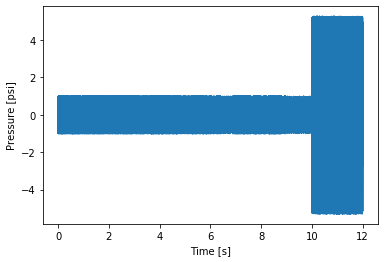

In [4]:
noise = 2*np.random.rand(300000)-1
t = np.linspace(0,300000/25000,300000)
sin_amp = 0.7
damp_amp = 0.7
interm_sig = gen_intermittent(noise, t, sin_amp, damp_amp)
plt.figure()
plt.plot(t, interm_sig)
plt.ylabel('Pressure [psi]')
plt.xlabel("Time [s]")
plt.show()

We split the signal into overlapping time windows that can be passed to the ML algorithm for classification. This turs our 1D signal into a 2D matrix.

In [28]:
window_length = 4000
stepsize = 100
padded_sig = np.pad(interm_sig.reshape(-1), (0, window_length), 'constant')
rolling_sig = np.zeros((np.floor_divide(interm_sig.shape[0], stepsize),
                                             window_length))
for i in range(window_length-1):
    rolling_sig[:, i] = padded_sig[i:-(window_length+1-i):stepsize]

We create three labels for the data using the peak-to-peak (p2p) pressure ofthe signal: 'noise', 'transition' and 'limit cycle'. The 'limit cycle' calss is defined as anything over 4 psi p2p, the 'transition' class as 2s of data before that and everything else is labelled as 'stable'.

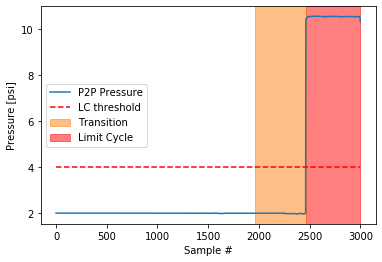

In [42]:
y_labels = np.zeros(rolling_sig.shape[0])
p2ps = rolling_sig.max(axis=1)-rolling_sig.min(axis=1)
y_labels[p2ps>4] = 2
start_insta = np.argmax(y_labels)
dt = np.median(np.diff(t))
start_trans = int(start_insta - 2/(stepsize*dt))
y_labels[start_trans:start_insta] = 1
plt.figure()
plt.plot(p2ps, label='P2P Pressure')
#plt.plot(y_labels)
plt.plot([0,3000],[4, 4],'r--', label='LC threshold')
handles2, labels2 = plt.gca().get_legend_handles_labels()
texts = ['Transition', 'Limit Cycle']
colors = ['C1', 'red']
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]), alpha=0.5 ) for i in range(len(texts)) ]
plt.legend(handles= handles2 + patches, loc='center left', bbox_to_anchor=(0, 0.5))
plt.axvspan(start_insta, 3000, color='red', alpha=0.5)
plt.axvspan(start_trans, start_insta, color='C1', alpha=0.5)
plt.xlabel('Sample #')
plt.ylabel('Pressure [psi]')
plt.show()

Carry out DFA on the signal

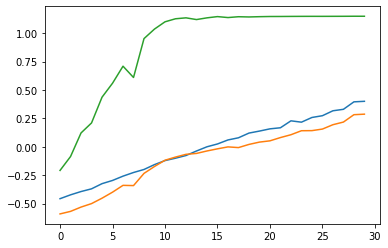

In [64]:
DFA_sig, ws, time_sig = DFA_transform(interm_sig, t)
DFA_sig = DFA_sig.T
plt.figure()
plt.plot(DFA_sig[500, :], label = 'noise')
plt.plot(DFA_sig[2450, :], label = 'transition')
plt.plot(DFA_sig[2900, :], label = 'limit cylce')
plt.show()

Create training and testing data sets

In [87]:
X_train, X_test, y_train, y_test = train_test_split(DFA_sig, y_labels, test_size=0.33, random_state=42, shuffle=False)

In [88]:
h2o.init()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)#[np.max(np.isnan(X_test), axis=1), :])
train_df = pd.DataFrame(X_train, columns=["DFA_{:.2f}".format(w) for w in ws])
train_df['label'] = y_train
test_df = pd.DataFrame(X_test, columns=["DFA_{:.2f}".format(w) for w in ws])
test_df['label'] = y_test
train = h2o.H2OFrame(train_df)
train['label'] = train['label'].asfactor()
test = h2o.H2OFrame(test_df)
test['label'] = test['label'].asfactor()
aml = H2OAutoML(max_models=1, seed=1, max_runtime_secs=300)
aml.train(x=["DFA_{:.2f}".format(w) for w in ws], y='label', training_frame=train, validation_frame=test)
model_ids = list(aml.leaderboard.as_data_frame()['model_id'].values)
aml.leaderboard.head()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,8 mins 56 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,7 months and 19 days !!!
H2O cluster name:,H2O_from_python_212687364_e8s6gp
H2O cluster total nodes:,1
H2O cluster free memory:,1.734 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
15:01:04.639: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
15:01:04.642: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_20200925_150104,0.983349,0.0342387,0.800618,0.133928,0.0902109,0.008138


In [97]:
temp_model = h2o.get_model(model_ids[0])
test_df = pd.DataFrame(DFA_sig, columns=["DFA_{:.2f}".format(w) for w in ws])
preds = temp_model.predict(h2o.H2OFrame(test_df)).as_data_frame().values

Parse progress: |█████████████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


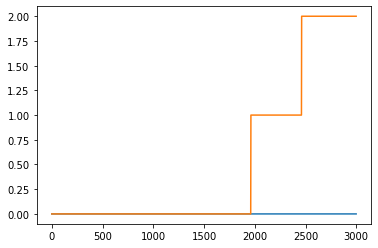

In [99]:
plt.figure()
plt.plot(np.argmax(preds, axis=1))
plt.plot(y_labels)
plt.show()